<a href="https://colab.research.google.com/github/Kira1108/SQL-DIE/blob/main/ChatPlayGround.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Embedding采用的模型和chatGPT, GPT系列的模型都不同，所以不能和GPT系列有什么直接集成的可能可能。      
Embedding作为一个单独的知识库搜索，以文本输入， 文本输出的形式。 让chatGPT给出输入文本，Embedding给出输出文本，chatGPT仅处理文本。

In [ ]:
from IPython.display import clear_output
!pip install langchain
!pip install openai
!git clone https://github.com/Kira1108/simple-chat.git
!pip install simple-chat
!pip install tiktoken
clear_output()

In [ ]:
#@title Add openai api key
import os
os.environ['OPENAI_API_KEY'] = ""

## 1. Create Embedding

In [ ]:
import tiktoken
import pandas as pd
import numpy as np
import openai
from dataclasses import dataclass

@dataclass
class EmbeddingParams:
    """
    Desc: Parameters of embedding model(encoding -> embedding)

    Parameters:
        embedding_model: str, openai model to create embedding vectors (GPT model name)
        embedding_encoding: str, the encoding schema used for the embedding (Tokenizer Name)
        max_tokens: max allowed tokens, for text-embedding-ada-002, this should be
            smaller than 8191 tokens

    Note:
        Please refer to https://platform.openai.com/docs/guides/embeddings/what-are-embeddings
    """
    embedding_model:str = "text-embedding-ada-002"
    embedding_encoding:str = "cl100k_base"
    max_tokens:float = 8000

class DocumentEmbedding:

    def __init__(self, df, column = 'texts', embedding_params = None):
        self.df = df
        self.embedding_params = embedding_params if embedding_params else EmbeddingParams()
        self.column = column
        self.encoding = tiktoken.get_encoding(self.embedding_params.embedding_encoding)

    def calculate_tokens(self):
        self.df['n_tokens'] = self.df[self.column].apply(lambda x: len(self.encoding.encode(x)))

    def embed_single(self, text):
        text = text.replace("\n", " ")
        return openai.Embedding.create(input = [text], model=self.embedding_params.embedding_model)['data'][0]['embedding']

    def create_embedding(self):
        self.calculate_tokens()
        self.df["embedding"] = self.df[self.column].apply(
            lambda x: self.embed_single(x)
            )

    def dump(self, fp = "embedding.csv"):
        self.df.to_csv(fp, index = False)
        print("Dumped embedding to {}".format(fp))

    @classmethod
    def load(cls, fp = "embedding.csv"):
        df = pd.read_csv(fp)
        df['embedding'] = df['embedding'].apply(eval).apply(np.array)
        return df

In [ ]:
# for a given dataframe df
df = pd.DataFrame(['Welcome to school',
                   'Nice to see you in school',
                   'It is very happy to see you here in school',
                   'The weather is good today, its sunny all day',
                   "A shinny sun is in the sky",
                   'It is good weathcer with a sun in the sky'], columns = ['texts'])

# create embedding and save embedding
embed = DocumentEmbedding(df, "texts")
embed.create_embedding()
embed.dump()

# load embedding
embedding =DocumentEmbedding.load()

Dumped embedding to embedding.csv


In [ ]:
embedding

,texts,n_tokens,embedding
0,Welcome to school,3,"[0.006322845350950956, 0.014436447992920876, -..."
1,Nice to see you in school,6,"[0.006240431219339371, -0.003838322823867202, ..."
2,It is very happy to see you here in school,10,"[0.0042152199894189835, -0.0031464393250644207..."
3,"The weather is good today, its sunny all day",10,"[0.001616460969671607, 0.01902160979807377, 0...."
4,A shinny sun is in the sky,8,"[0.02212405949831009, 0.001005280064418912, -0..."
5,It is good weathcer with a sun in the sky,12,"[0.007704227697104216, 0.00914715975522995, 0...."


## 2. Visualize Embedding


More Embedding = More money

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

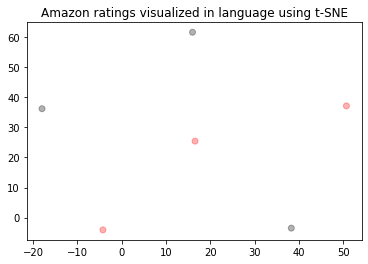

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
 
embeddings = np.array(embedding.embedding.tolist())
 
# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity = 5, random_state=42)
vis_dims = tsne.fit_transform(embeddings)
 
colors = ["red", "black"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = [0,0,0,1,1,1]
 
colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
plt.title("Amazon ratings visualized in language using t-SNE")

## 3. Clustering

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
 
matrix = np.vstack(embeddings)
n_clusters = 2
 
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42, n_init = 'auto')
kmeans.fit(matrix)
prediction_df = pd.DataFrame(df.texts)
prediction_df['prediction'] = kmeans.labels_
prediction_df

,texts,prediction
0,Welcome to school,1
1,Nice to see you in school,1
2,It is very happy to see you here in school,1
3,"The weather is good today, its sunny all day",0
4,A shinny sun is in the sky,0
5,It is good weathcer with a sun in the sky,0


## 4. Zero shot classification

In [ ]:
from openai.embeddings_utils import cosine_similarity, get_embedding
 
labels = ['school', 'sunny']
label_embeddings = np.array([get_embedding(label, engine='text-embedding-ada-002') for label in labels], dtype = np.float16)
 
def label_score(review_embedding, label_embeddings):
   return cosine_similarity(review_embedding, label_embeddings[1]) - cosine_similarity(review_embedding, label_embeddings[0])

for i in range(6):
    prediction = 'sunny' if label_score(embeddings[i], label_embeddings) > 0 else 'school'
    print(df.iloc[i].texts, ": ----",prediction)

Welcome to school : ---- school
Nice to see you in school : ---- school
It is very happy to see you here in school : ---- school
The weather is good today, its sunny all day : ---- sunny
A shinny sun is in the sky : ---- sunny
It is good weathcer with a sun in the sky : ---- sunny


## 4. User and Product Embeddings

In [ ]:
!curl -o fine_food_reviews_1k.csv https://raw.githubusercontent.com/openai/openai-cookbook/86105298b0fb6369b69ef995bf242a42277c890d/examples/data/fine_food_reviews_1k.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  425k  100  425k    0     0  4785k      0 --:--:-- --:--:-- --:--:-- 4785k


In [ ]:
fo = pd.read_csv("fine_food_reviews_1k.csv")

In [ ]:
fo

,Unnamed: 0,Time,ProductId,UserId,Score,Summary,Text
0,0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...
1,1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos..."
2,2,1351123200,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...
3,3,1351123200,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...
4,4,1351123200,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...
...,...,...,...,...,...,...,...
995,995,1351209600,B004OQLIHK,AKHQMSUORSA91,5,Delicious!,I have ordered these raisins multiple times. ...
996,996,1351209600,B0006349W6,A21BT40VZCCYT4,5,Good Training Treat,My dog will come in from outside when I am tra...
997,997,1351209600,B00611F084,A6D4ND3C3BCYV,5,Jamica Me Crazy Coffee,Wolfgang Puck's Jamaica Me Crazy is that wonde...
998,998,1351209600,B005QKH5HA,A3LR9HCV3D96I3,5,Party Peanuts,Great product for the price. Mix with the Asia...


- 太费钱了，对每一行，获取embeddin, Summary是摘要， Text是正文， concat到一起，获取每一行的embedding。  
- Group by user_id, np.mean(embedding) 获得user embedding
- Group by productId, np.mean(embedding) 获得product embedding
- 用户和产品就都有向量表示了

## 5. 基于Embedding的文本搜索 - Sql表搜索

In [ ]:
texts = [
    "Shady make love with Ludy last night",
    "Shady is a software engineer",
    "Ludy is a musician",
    "Shady is Ludy's girl friend"
]

df = pd.DataFrame(texts, columns = ['texts'])

embed = DocumentEmbedding(df, "texts")
embed.create_embedding()
embed.dump()

# load embedding
embedding =DocumentEmbedding.load()

Dumped embedding to embedding.csv


In [ ]:
from openai.embeddings_utils import get_embedding, cosine_similarity
 
def search_answers(df, query, n=1, pprint=True):
    embedding = get_embedding(query, engine='text-embedding-ada-002')
    df['similarities'] = df.embedding.apply(lambda x: cosine_similarity(x, embedding))
    res = df.sort_values('similarities', ascending=False).head(n)
    return res
 
def qa(q):
    res = search_answers(embedding, q, n=1)
    answer = res.texts.iloc[0]
    print(answer)

In [ ]:
qa("What is Shady's job?")

Shady is a software engineer


In [ ]:
qa("what is Ludy's job")

Ludy is a musician


In [ ]:
qa("What is the relationship between Shady and Ludy")

Shady is Ludy's girl friend


In [102]:
qa("What does Ludy to last night?")

Shady make love with Ludy last night


## 6. 更廉价的搜索 - HuggingFace

In [ ]:
!pip install transformers
!pip install datasets

In [159]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F

sentences = [
    'Artificial intelligence is cool',
    'Transformer is an advanced deeplearning model',
    'The weather is good today',
    'Word to Vector increase the ability of NLP',
    'It is going to rain tomorrow',
    'NLP embedding are very important'
]


model_ckpt = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
encode_input = tokenizer(sentences, padding = True, truncation = True, return_tensors = 'pt')
model = AutoModel.from_pretrained(model_ckpt)

with torch.no_grad():
    model_output = model(**encode_input)

token_embeddings = model_output.last_hidden_state
print(f"Token embeddings shape {token_embeddings.size()}")

np_embedding = token_embeddings.numpy()

Token embeddings shape torch.Size([6, 12, 384])


In [160]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min = 1e-9)

sentence_embeddings = mean_pooling(model_output, encode_input['attention_mask'])
sentence_embeddings = F.normalize(sentence_embeddings, p = 2, dim = 1)
print(f"Sentence embeddings shape: {sentence_embeddings.size()}")

Sentence embeddings shape: torch.Size([6, 384])


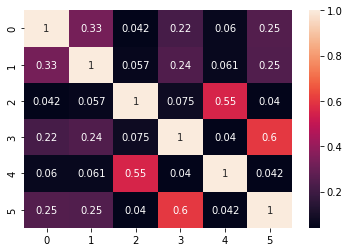

In [161]:
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
scores = np.zeros((sentence_embeddings.shape[0], sentence_embeddings.shape[0]))
sentence_embeddings = sentence_embeddings.detach().numpy()

for idx in range(sentence_embeddings.shape[0]):
    scores[idx,:] = cosine_similarity([sentence_embeddings[idx]], sentence_embeddings)[0]

sns.heatmap(scores, annot = True)
plt.show()

In [209]:
from dataclasses import dataclass
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity

@dataclass
class SentenceEmbedder:

    model_ckpt:str = "sentence-transformers/all-MiniLM-L6-v2"
    normalize:bool = False

    def __post_init__(self):
        tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
        model = AutoModel.from_pretrained(model_ckpt)

    def tokenize(self, sentences):
        return tokenizer(sentences, padding = True, truncation = True, return_tensors = 'pt')

    def mean_pooling(self, model_output, attention_mask):

        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = (
            attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        )
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min = 1e-9)


    def __call__(self, sentences):
        encoder_input = self.tokenize(sentences)

        with torch.no_grad():
            model_output = model(**encoder_input)

        sentence_embeddings = self.mean_pooling(model_output,encoder_input['attention_mask'] )
        if self.normalize:
            sentence_embeddings = F.normalize(sentence_embeddings, p = 2, dim = 1)
        return sentence_embeddings.numpy()

In [212]:
ddls = [
    "create table user_info(user_id int primary)",
    "create table user_pay(create_time datetime, order_id string, amout float, user_id int)",
    "create table user_address(user_id int primary key, address text, user_country string)",
    "create table product(product_id primary key, product_name string, product_price float)"
]

embedder = SentenceEmbedder()
ddl_embeddings = embedder(ddls)

def find_table(query_string:str):
    query_embedding = embedder([query_string])
    idx =np.argmax(cosine_similarity(query_embedding, ddl_embeddings))
    return ddls[idx]

String Query由chatGPT生成

In [213]:
find_table("A table contains financial information")

'create table user_pay(create_time datetime, order_id string, amout float, user_id int)'

In [217]:
find_table("A table contains location information")

'create table user_address(user_id int primary key, address text, user_country string)'

In [215]:
find_table("A table contains basic information")

'create table user_info(user_id int primary)'

In [216]:
find_table("A table contains goods information")

'create table product(product_id primary key, product_name string, product_price float)'